# Mount GDrive and install dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons contractions emoji ekphrasis --quiet

     |████████████████████████████████| 1.1 MB 31.4 MB/s 
     |████████████████████████████████| 175 kB 69.2 MB/s 
     |████████████████████████████████| 83 kB 2.6 MB/s 
     |████████████████████████████████| 287 kB 78.1 MB/s 
     |████████████████████████████████| 106 kB 76.0 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 


Load dependencies required

In [ ]:
import tensorflow as tf
import keras

from keras import Model, Sequential
from keras.layers import Embedding, TextVectorization, Input, LSTM, Bidirectional, Dropout, Dense, SpatialDropout1D, Attention, Conv1D, MaxPooling1D, Add, Flatten, Reshape, GRU
import keras.backend as K
from keras.losses import Loss
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from keras.initializers import Constant
from keras.regularizers import l2
from keras.metrics import Mean

from tensorflow.keras.losses import SparseCategoricalCrossentropy, Reduction
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import tensorflow_addons as tfa

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
import numpy as np
import re
from dataclasses import dataclass

import contractions, emoji

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [ ]:
pd.set_option('display.max_colwidth', None)

# Emotion detection

The assignment is an NLP task for emotion detection. In particular, given a text message, the model has to predict the most appropriate emotion among the ones available. 

## Key aspects

### Preprocessing

For the purpose of the task, and in general for NLP problems, some preprocessing of the text is required to transform texts in a different way and handle them properly in the neural network, for example by lowering the case, removing elongated words and so on.

### Tokenization

Afterwards, the input of the model must be a numerical one, but since texts are strings they need to be transformed to integers. For this reason, the input is firstly tokenized and then an numerical value is associated.

### Model

There are different choices to model NLP problems: CNN, RNN and Transformers. Design choices will be better discussed in the following sections

## Dataset

The dataset contains entries of messages posted maybe in social networks, where for each of them there is an emotion associated, describing the intended sentiment of the text. In this case, classes available are joy, neutral, surprise, anger, sadness, disgust, fear.

The entire dataset has 54263 entries and is given splitten in three parts:
- Training: 43410 entries (80%)
- Validation: 5426 entries (10%)
- Testing: 5427 entries (10%)

### Zipped dataset file is moved to current working directory

In [ ]:
!cp /content/drive/MyDrive/DLExam/data.zip /content

In [ ]:
!mkdir dataset
!unzip data.zip -d dataset

mkdir: cannot create directory ‘dataset’: File exists
Archive:  data.zip
replace dataset/test_ekmann.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Datasets read as pandas Dataframes

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df_train_raw = pd.read_csv('dataset/train_ekmann.csv')
df_val_raw = pd.read_csv('dataset/val_ekmann.csv')
df_test_raw = pd.read_csv('dataset/test_ekmann.csv')

In [ ]:
df_train_raw.rename(columns = {"Text": "text", "Emotion": "emotion", "Id": "id"}, inplace=True)
df_val_raw.rename(columns = {"Text": "text", "Emotion": "emotion", "Id": "id"}, inplace=True)
df_test_raw.rename(columns = {"Text": "text", "Emotion": "emotion", "Id": "id"}, inplace=True)

### Closer look at datasets

There are three columns: text, emotion and id

For example, by showing the training dataset there can be easily seen the source of texts. In fact, they are probably coming from social networks, e.g. Twitter or Reddit, mainly from comments/replies or tweets. 

Also, as said before, some preprocessing must be done to uniformly represent the text, which will be later described.

In [ ]:
df_train_raw.head()

,text,emotion,id
0,My favourite food is anything I didn't have to cook myself.,neutral,eebbqej
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",neutral,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,anger,eezlygj
3,To make her feel threatened,fear,ed7ypvh
4,Dirty Southern Wankers,anger,ed0bdzj


A look at the distribution of the "emotion" class is therefore needed to better know percentages of each sentiment in the dataset.

In fact, there can be seen that between datasets the distribution is very similar, but overall two main classes, "joy" and "neutral", are more distributed than others, especially with respect to "disgust" and "fear".

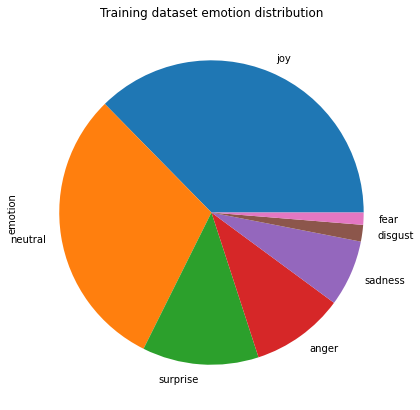

In [ ]:
df_train_raw.emotion.value_counts().plot(kind="pie", figsize=(7, 7), title="Training dataset emotion distribution");

In [ ]:
train_count = df_train_raw.emotion.value_counts(normalize=True)
val_count = df_val_raw.emotion.value_counts(normalize=True)
test_count = df_test_raw.emotion.value_counts(normalize=True)

print("--- Distribution of Emotion in the train set ---")
print(train_count)

print("\n--- Distribution of Emotion in the validation set ---")
print(val_count)

print("\n--- Distribution of Emotion in the test set ---")
print(test_count)

--- Distribution of Emotion in the train set ---
joy         0.373578
neutral     0.302833
surprise    0.123635
anger       0.098894
sadness     0.070445
disgust     0.017692
fear        0.012923
Name: emotion, dtype: float64

--- Distribution of Emotion in the validation set ---
joy         0.382787
neutral     0.301880
surprise    0.115002
anger       0.102285
sadness     0.067084
disgust     0.017324
fear        0.013638
Name: emotion, dtype: float64

--- Distribution of Emotion in the test set ---
joy         0.364474
neutral     0.303667
surprise    0.124747
anger       0.105399
sadness     0.065414
disgust     0.021375
fear        0.014925
Name: emotion, dtype: float64


### Categorize emotions

Emotions are categorized from strings to integer labels, in order to be handled by the model and to compute the metric

In [ ]:
id_labels = {'joy': 0, 'neutral': 1, 'surprise': 2, 'anger': 3, 'sadness': 4, 'disgust': 5, 'fear': 6}

df_train_raw.emotion.replace(id_labels, inplace=True)
df_val_raw.emotion.replace(id_labels, inplace=True)
df_test_raw.emotion.replace(id_labels, inplace=True)

## Preprocessing

The preprocessing pipeline is ofter necessary when handling texts, but before doing so, it is important to notice which things occured in the dataset and the way them could be processed, especially for not losing the meaning of texts with respect to the assigned emotion. 

In fact similar senteces can have opposite emotions for example by only changing punctuations.

From this observations, of course a tradeoff must be found to better generalize the dataset for the model but at the same time keeping the semantic almost the same. 

Firstly, a better loook at some texts to see why some choices were made.

In [ ]:
print(f"Example of an uppercase message: {df_train_raw.iloc[62].text}\n")
print(f"Example of a message with emojis: {df_train_raw.iloc[425].text}\n")
print(f"Example of an elongated message: {df_train_raw.iloc[40211].text}\n")
print(f"Example of a message with a contracted form: {df_train_raw.iloc[992].text}")

Example of an uppercase message: WHAT ARE YOU DOIN [NAME]?

Example of a message with emojis: I appreciate this post, so it’s appropriate in my eyes 😀

Example of an elongated message: Somewhere in Ohiooooooooo*

Example of a message with a contracted form: Don't worry about it.


It can be seen that some texts falling in one of the previous examples must be processed somehow.

For example, contracted words must be splitten and considered differently, in this way the model can better capture similar sentences.

Another example are elongated words which, even though they are written to better capture a precise emotion, I've decided to remove the "longer" part and keep them in "normal form", for a better tokenization, which will be discussed in the next section.

In [ ]:
# the "id" column is not relevant for the task
def drop_irrelevant_column(df_pre, cols=["id"]):
    return df_pre.drop(cols, axis=1)

# lowerize the text column of datasets
def lowerize(df_pre):
    df_pre.text = df_pre.text.str.lower()
    return df_pre

def remove_punctuations(df_pre):
    # df_pre.text = df_pre.text.replace('|'.join([re.escape(c) for c in list("!#$%&'()*+,-./:;<=>?@\^_`{|}~")]), 
    #                                   "", 
    #                                   regex=True)
    df_pre.text = df_pre.text.replace('|'.join([re.escape(c) for c in list("#$%&*/:\^_{|}~")]), 
                                      "", 
                                      regex=True)
    return df_pre

def convert_emojis(df_pre):
    df_pre.text = df_pre.text.apply(lambda x: emoji.demojize(x))
    return df_pre

# removed contractions
def split_contractions(df_pre):
    df_pre.text = df_pre.text.apply(contractions.fix)
    return df_pre


The Ekphrasis preprocessor is a widely used tokenizer for NLP tasks, especially for the ones considering social networks messages as input of their model ([1](https://aclanthology.org/2020.smm4h-1.31/)).

For this reason, I've decided to implement it and choose only some types of the possible options the library can handle, mainly to focus on some important key aspects, which are:

- Numerical quantities, such as money, time, date, number and phone: they give little insights on the emotion related to the message and it's better to keep them generalized, in this way they are replaced by a special token, like "\<number\>".
- Elongated, repeated, emphasis and censored words are transformed in their "normal form", that is the one with higher probability among the candidate words of a Twitter corpus.
- A social tokenizer is used to better capture emojis and other expressions like dates, times and more based on social behaviour.
- A corrector for mispelled words

In [ ]:
text_processor = TextPreProcessor(
    normalize= ['money', 'user', 'time', 'date', 'number', 'phone'],
    annotate={"elongated", "repeated", 'emphasis', 'censored'},
    fix_html=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    segmenter="twitter", 
    corrector="twitter", 
    unpack_contractions=False,
    spell_correct_elong=True,
    spell_correction=True,
    fix_text=True,    
    dicts=[emoticons]
)

Reading twitter - 1grams ...


### Preprocessing pipeline

In this step, datasets are preprocessed and transformed by applying all the things described so far.

In [ ]:
def df_preprocessing(df_pre):
    df_pre = drop_irrelevant_column(df_pre)
    df_pre = lowerize(df_pre)
    df_pre = convert_emojis(df_pre)
    df_pre = split_contractions(df_pre)
    
    df_pre.text = df_pre.text.apply(lambda x: ' '.join(text_processor.pre_process_doc(x)).strip())

    for patt in [r"<elongated>", r"<repeated>"]:
        df_pre.text = df_pre.text.replace(patt, '', regex=True)

    df_pre = remove_punctuations(df_pre)

    return df_pre

In [ ]:
df_train = df_preprocessing(df_train_raw)
df_val = df_preprocessing(df_val_raw)
df_test = df_preprocessing(df_test_raw)

In [ ]:
df_train.text.replace("\[ name \]", "[name]", regex=True, inplace=True)
df_val.text.replace("\[ name \]", "[name]", regex=True, inplace=True)
df_test.text.replace("\[ name \]", "[name]", regex=True, inplace=True)

In [ ]:
print(f"Example of an uppercase message: {df_train.iloc[62].text}\n")
print(f"Example of a message with emojis: {df_train.iloc[425].text}\n")
print(f"Example of an elongated message: {df_train.iloc[40211].text}\n")
print(f"Example of a message with a contracted form: {df_train.iloc[992].text}")

Example of an uppercase message: what are you doin [name] ?

Example of a message with emojis: i appreciate this post , so it is appropriate in my eyes  grinningface 

Example of an elongated message: somewhere in ohio  

Example of a message with a contracted form: do not worry about it .


### Duplicates

Finally, I've noticed some duplicates on datasets (entries with same text and same emotion), therefore they are removed.

In test and validation datasets there aren't duplicated entries with different emotions, hence they can be safely removed.

On the contrary, the train set has many duplicates with different emotions, so I've decided to remove only the ones with same label and same text

In [ ]:
df_val.drop_duplicates(subset=["text", "emotion"], keep="first", ignore_index=True, inplace=True)
df_test.drop_duplicates(subset=["text", "emotion"], keep="first", ignore_index=True, inplace=True)

In [ ]:
df_train.drop_duplicates(subset=["text", "emotion"], keep=False, ignore_index=True, inplace=True)

## Tokenization

The tokenization consists in transforming the input into units to be vectorized as tokens. This means that from words/subwords are created tokens which are mapped to integers and then stored in an array. 

The array has two special indexes: 0, 1, which are respectively used for padding and OOV/[UNK] tokens, the latter is assigned when a token of a text is not present in the array of tokens generated. In fact, a maximum number of tokens is defined, as will be better observed.

### Length of words in each dataset

A look at the maximum number of words is necessary, because in this way I can better define the fixed size of encoded tokens.

The median in this case is 15 for all datasets, in addition by looking at the box plot of the training set, since it has the longest word, the distribution of the length is mostly concentrated in short words, therefore I've decided to go with a length of 64.

In [ ]:
train_count = df_train.text.apply(lambda x: len(x.split(" ")))
val_count = df_val.text.apply(lambda x: len(x.split(" ")))
test_count = df_test.text.apply(lambda x: len(x.split(" ")))

print(f"Max words in a train sample: {train_count.median()}")
print(f"Max words in a val sample: {val_count.median()}")
print(f"Max words in a test sample: {test_count.median()}")

Max words in a train sample: 15.0
Max words in a val sample: 15.0
Max words in a test sample: 15.0


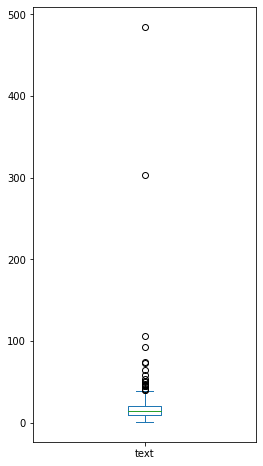

In [ ]:
train_count.plot.box(figsize=(4, 8))

### Vectorize layer

The TextVectorization layer of Keras heps in preparing the text data to be integer sequences for the model.

Firsty, it has 3 hyperparameters to be tuned appropriately: the vocabulary size, the max length and the embedding dimension.

#### VOCAB_SIZE

The vocabulary size defines the maximum number of tokens in the array, and, as can be noticed in the literature [1](https://www.hindawi.com/journals/mpe/2021/5536560/), [2](https://www.researchgate.net/profile/Andrei-Paraschiv/publication/337007402_UPB_at_GermEval-2019_Task_2_BERT-Based_Offensive_Language_Classification_of_German_Tweets/links/5dbff8a592851c818028a983/UPB-at-GermEval-2019-Task-2-BERT-Based-Offensive-Language-Classification-of-German-Tweets.pdf]), a good one is between 15000 and 20000 tokens. 

While tuning the hyperparameters I've found that 20K is the most appropriate, especially considering the embedding layer which will be seen in the next section.

#### MAX LENGTH
The maximum length, as said before, is 64.

#### EMBED_DIM

Finally, using a pretrained embedding layer, such GloVe in this case, I was costrained by four embedding dimensions: 50, 100, 200, 300. I decided to test them all, but the latest one (300) was the most succesful in getting higher metrics, therefore I decided to go with that.

It's one of the most frequent in the literature and in this case many words of the training datasets (~80%) were already mapped into the embedding space, hence this proves the better results.

In [ ]:
@dataclass
class Vectorizing:
    VOCAB_SIZE = 20000
    MAX_LEN = 64
    EMBED_DIM = 300

conf_m1 = Vectorizing()

In [ ]:
def get_vectorize_layer(texts, vocab_size, max_seq):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=None,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)
    
    return vectorize_layer

### Encoding of the input

At this point, datasets are transformed into tensors, by using the vectorization layer as a "vocabulary" which performes associations between token strings and integers.

In [ ]:
def encode(texts, layer):
    encoded_texts = layer(texts)
    return encoded_texts.numpy()

def get_vectorized_dataset(text, emotion, layer):
    return encode(text, layer), to_categorical(emotion)

def get_tensor_dataset(x, y, buffer=1000, batch=32):
    # return (
    #     tf.data.Dataset.from_tensor_slices((x, y))
    #     .shuffle(buffer, seed=conf_m1.SEED)
    #     .batch(batch))
    return (tf.data.Dataset.from_tensor_slices((x, y)))

In [ ]:
vectorize_layer = get_vectorize_layer(
    df_train.text.values.tolist(),
    conf_m1.VOCAB_SIZE,
    conf_m1.MAX_LEN
)

In [ ]:
x_train, y_train = get_vectorized_dataset(df_train.text.values, 
                                            df_train.emotion.values,
                                            vectorize_layer)

x_val, y_val = get_vectorized_dataset(df_val.text.values, 
                                        df_val.emotion.values,
                                        vectorize_layer)

x_test, y_test = get_vectorized_dataset(df_test.text.values, 
                                        df_test.emotion.values,
                                        vectorize_layer)

train_classifier_ds = get_tensor_dataset(x_train, y_train)
val_classifier_ds = get_tensor_dataset(x_val, y_val)

xtest_raw_ds = (tf.data.Dataset.from_tensor_slices(x_test).batch(256))

## Embedding layer

I avoided the one-hot-encoding essentially for two reasons: it has a sparse representation, hence it requires too much memory, and also it cannot capture semantic relationship between tokens. 

In general, many words have a similar meaning (synonyms), and in order to capture this behaviour in NNs, a layer embedding is necessary to determine a geometric space and transformation from one word to another, in order to exploit better their connections and allowing a better generalization of the model.

Even though the embedding layer can be trained, I reached better performance, as expected, by using a pretrained layer: **GloVe**.

It is a pretrained word embeddings layer of 40,000 tokens with an embedding dimension of 300, so the geometrical space has SOTA performance and it is widely used in the literature.

In this way I also achieve faster training and overall better performance.

### Download

In [ ]:
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip -q glove.6B.zip

--2022-06-30 16:56:50--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 52.71.31.33, 34.192.62.10, 2600:1f18:147f:e800:e3ed:f4c9:35c2:ea6b, ...
Connecting to huggingface.co (huggingface.co)|52.71.31.33|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B%20filename%3D%22glove.6B.zip%22 [following]
--2022-06-30 16:56:50--  https://cdn-lfs.huggingface.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=attachment%3B%20filename%3D%22glove.6B.zip%22
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 52.85.151.94, 52.85.151.109, 52.85.151.45, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|52.85.151.94|:443... connected.
HTTP request sent, awaiting response.

### Configure pretrained embedding

In [ ]:
path_to_glove_file = f"glove.6B.{conf_m1.EMBED_DIM}d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Found 400001 word vectors.


In [ ]:
voc = vectorize_layer.get_vocabulary()
voc_size = vectorize_layer.vocabulary_size()
word_index = dict(zip(voc, range(voc_size)))

hits = 0
misses = 0

embedding_matrix = np.zeros((conf_m1.VOCAB_SIZE, conf_m1.EMBED_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print(f"Converted {hits} words ({misses} misses)")

Converted 17826 words (2174 misses)


## Model

There are many approaches used in the literature [1](https://paperswithcode.com/sota/sentiment-analysis-on-yelp-binary) with state of the art performance, which are:

- Convolutional Neural Networks (CNNs)
- Recurrent Neural Networks (RNNs)
- Transformer architectures

Until 2017, RNNs were the state of the art for sentiment tasks and they generally offered better performance with respect to CNNs. 

However, in recent years, complex networks evolved adopting the Transformer architecture, consisting of Transformer encoder and decoder containing self-attention mechanism, such as the Multihead attention layer. The key aspect is the ability to make features context-aware, basically by giving context to words in a sentence, which an Embedding layer could not do properly. 

Having said that, given the enourmous number of parameters required by this type of model, mainly because pretrained models like BERT (or variants) are used, and also because the dataset doesn't contain long words and it is not so big [2](https://developers.google.com/machine-learning/guides/text-classification/), for this classification task I prefer using a lightweight model: **BiLSTM**.

---

### My network: BiLSTM

A RNN layer, such as LSTM that I used in this project, processes the sequence more times, keeping informations of the states visited so far. This characteristic, in my opinion, is very suitable for this task, because it permits to better capture features of each sentence. 

In addition, I decided to go a little forward and implement the RNN as a Bidirectional layer of LSTMs in order to scan the input in both direction: in natural order and reversed. [3](https://dl.acm.org/doi/abs/10.1145/3194206.3194240)

I have also noticed that only one layer was not sufficient, I decided to stack multiple layers mainly to increase the representational power of features captured by the network.

#### Avoid overfitting

Given the nature of this dataset, it is prone to overfit very easily, in less than 5 epochs. For this reason, some regularisations are necessary to restrain overfitting and resulting in a better model.

Firsly, I used a SpatialDropout after the embedding layer, with a rate of 0.3, which results in *increased* performance [4](https://www.mdpi.com/2076-3417/12/7/3641). 

Also, three Bidirectional LSTM layers suffer from overfitting, but I decided to not apply dropout during the iteration of the LSTM layer, but just after that [5](https://arxiv.org/abs/1409.2329), applying a Dropout layer with rate 0.3 to the output of each BiLSTM layer.

FInally, weight decay was applied to the recurrent regularizer of each LSTM layer, through a L2 regularization penalty with a factor of 0.02.

The main callback used was *ReduceLROnPlateau* with a factor of 0.3 after just one epoch of worse validation loss. Since the dataset tends to overfit really fast I decided to choose a small patience parameter, with the learning rate reduce by a *not so irrelevant* factor, in order to reach a better convergence.

The initial learning rate was set to 0.005 with a batch size of 80. I've tried other different learning rates, with they have a slower convergence or tend to overfit really fast.

#### Network architecture

The network has an Embedding layer which takes vectorized sequences. Then, three Bidirectional LSTM layers are stacked and finally a Dense layer with a softmax activation function is used. 

The output is an array of class probabilities.

The loss function is *categorical crossentropy* and the optimizer is *Adam*.

In [ ]:
@dataclass
class Parameters:
    BATCH = 80
    LR = 5e-3
    L2 = 0.02
    SD_RATE = 0.3
    D_RATE = 0.3
    LSTM_UNITS = 128
    LSTM_LAYERS = 3

m1_para = Parameters()

In [ ]:
inputs = Input((conf_m1.MAX_LEN,), dtype=tf.int64)
embedded = Embedding(conf_m1.VOCAB_SIZE, 
                    conf_m1.EMBED_DIM, 
                    embeddings_initializer=Constant(embedding_matrix),
                    trainable=False,
                    mask_zero=True)(inputs)

x = SpatialDropout1D(m1_para.SD_RATE)(embedded)

for i in range(m1_para.LSTM_LAYERS):
    ret_seq = i != m1_para.LSTM_LAYERS - 1

    x = Bidirectional(LSTM(m1_para.LSTM_UNITS, return_sequences=ret_seq, recurrent_regularizer=l2(m1_para.L2)))(x)
    x = Dropout(m1_para.D_RATE)(x)

outputs = Dense(7, activation="softmax")(x)
model = Model(inputs, outputs)

opt = Adam(learning_rate=m1_para.LR)
model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=[tfa.metrics.F1Score(num_classes=7, average='macro')])
    
model.summary()

early_stopping = EarlyStopping(monitor="val_loss", patience=2)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=1, factor=0.3)

history = model.fit(train_classifier_ds.shuffle(1000, seed=42).batch(m1_para.BATCH), 
          validation_data=val_classifier_ds.shuffle(1000, seed=42).batch(m1_para.BATCH), 
          epochs=6,
          callbacks=[reduce_lr, early_stopping])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 64, 300)           6000000   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 64, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_12 (Bidirecti  (None, 64, 256)          439296    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 64, 256)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 64, 256)          3942

### Evaluate the model

The reached F1 macro average score reached is **0.6070**

In [ ]:
xtest_raw_ds = (tf.data.Dataset.from_tensor_slices(x_test).batch(256))

print(classification_report(np.argmax(y_test, axis=1), np.argmax(model.predict(xtest_raw_ds), axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.7870    0.7738    0.7804      1972
           1     0.6118    0.6448    0.6278      1647
           2     0.5759    0.5997    0.5876       677
           3     0.5038    0.4650    0.4836       572
           4     0.6012    0.5521    0.5756       355
           5     0.5859    0.5000    0.5395       116
           6     0.6322    0.6790    0.6548        81

    accuracy                         0.6585      5420
   macro avg     0.6140    0.6021    0.6070      5420
weighted avg     0.6587    0.6585    0.6582      5420



### Plot the loss and the F1 score

The callback ReduceLROnPlateau helps in reducing the loss function even more and reach higher score. In this case it is applied to the forth epoch by reducing the learning rate from 0.005 to 0.0015.

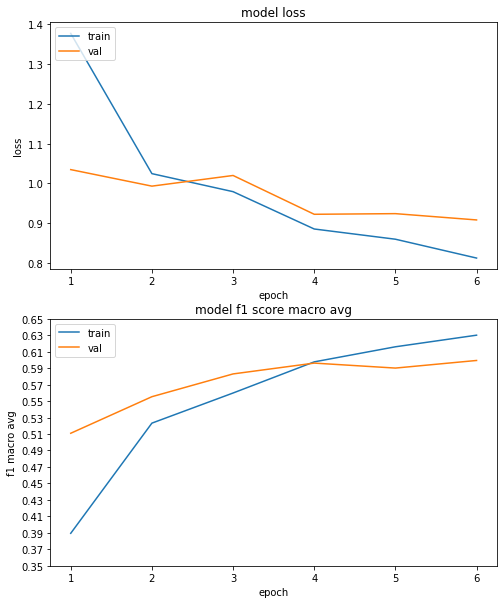

In [ ]:
fig, axs = plt.subplots(2, figsize=(8, 10))

x_len = np.arange(1, len(history.history['f1_score'])+ 1)

axs[0].plot(x_len, history.history['loss'])
axs[0].plot(x_len, history.history['val_loss'])
axs[0].set_title('model loss')
axs[0].set_ylabel('loss')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'val'], loc='upper left')
axs[0].set_xticks(x_len)

axs[1].plot(x_len, history.history['f1_score'])
axs[1].plot(x_len, history.history['val_f1_score'])
axs[1].set_title('model f1 score macro avg')
axs[1].set_ylabel('f1 macro avg')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'val'], loc='upper left')
axs[1].set_xticks(x_len)
axs[1].set_yticks(np.arange(0.35, 0.65, step=0.02))

fig.show()

### Save model

In [ ]:
model_name = "BiLSTM-6070"

In [ ]:
!mkdir '/content/drive/MyDrive/DLExam/BiLSTM-6070'
!mkdir '/content/drive/MyDrive/DLExam/BiLSTM-6070/Weights'
!mkdir '/content/drive/MyDrive/DLExam/BiLSTM-6070/Model'

In [ ]:
model.save_weights(f'/content/drive/MyDrive/DLExam/{model_name}/Weights/best_model.h5')

# Conclusions

Only one model has been developed, but its parameters have been tuned to avoid overfitting and reach higher metric values. 

To sum up, the F1 macro average reached on the test set is: **0.6070**.

The dataset is not considered to be in the current folder, so some paths should be changed to try it.